In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
Station_list = ["POLESOUT", "KISSR0.0", "LZ2", "S133", "TCNS228", "S135",
                "FEBIN", "MBOXSOU", "MH24000", "FEBOUT", "L005", "L008", "LZ40", "L004", "S308C",
                "PALMOUNT", "S169", "S236", "POLE3S", "RITTAE2", "LZ2FA", "L007", "PELBAY3", "L006", "LZ30"]
Variable_list = ['NITRATE+NITRITE-N', 'NITRITE-N', 'AMMONIA-N', 'KJELDAHL NITROGEN, TOTAL', 'PHOSPHATE, ORTHO AS P',
                 'PHOSPHATE, TOTAL AS P', 'NITRATE-N', 'SILICA', 'CARBON, TOTAL ORGANIC', 'CARBON, DISSOLVED ORGANIC',
                 'TOTAL NITROGEN', 'PHOSPHATE, DISSOLVED AS P', 'KJELDAHL NITROGEN, DIS', 'CARBON, TOTAL', 
                 'CARBON, TOTAL INORGANIC', 'NITROGEN, TOTAL DISSOLVED', 'CHLOROPHYLL-A(LC)']

Others = ['CHLOROPHYLL-A', 'PHEOPHYTIN', 'CHLOROPHYLL-A, CORRECTED', 
         'CHLOROPHYLL-C', 'CAROTENOIDS', 'CHLOROPHYLL-B', 'CHLOROPHYLL-A(LC)', 
         'PHEOPHYTIN-A(LC)', 'CHLOROPHYLL-B(LC)', 'RESP. PLANKTONIC']

Nitrogen_list = ['NITRATE+NITRITE-N', 'NITRITE-N', 'AMMONIA-N', 'KJELDAHL NITROGEN, TOTAL',
                'TOTAL NITROGEN','NITRATE-N','KJELDAHL NITROGEN, DIS','NITROGEN, TOTAL DISSOLVED']
Phosphorus_list = ['PHOSPHATE, ORTHO AS P','PHOSPHATE, TOTAL AS P','PHOSPHATE, DISSOLVED AS P']
Carbon_list = ['CARBON, TOTAL ORGANIC', 'CARBON, DISSOLVED ORGANIC','CARBON, TOTAL','CARBON, TOTAL INORGANIC']

In [5]:
summary = pd.read_csv("Variables_summary.csv")
Predictor_dict = dict({
    "POLESOUT":[],
    "KISSR0.0":[],
    "LZ2":[],
    "L005":[],
    "L008":[],
    "LZ40":[],
    "S308C":[],
    "POLE3S":[],
    "RITTAE2":[],
    "L007":[],
    "PELBAY3":[],
    "L006":[],
    "LZ30":[]
})

for station in list(Predictor_dict.keys()):
    station_summary = summary.loc[summary["Station"]==station, :]
    for variable in station_summary["Variable"]:
        if list(station_summary["Measurements in 2019"][station_summary["Variable"]==variable])[0] >= 10 and variable != 'CHLOROPHYLL-A(LC)' and variable not in Others:
            Predictor_dict[station].append(variable)

In [8]:
def Clean_date(df):
    """
    Transfer value in "Collection_Date" column in to Datetime object
    """
    for index, value in enumerate(df["Collection_Date"]):
        df["Collection_Date"][index] = datetime.strptime(value, '%Y-%m-%d %H:%M:%S')        
    return df

In [10]:
def Data_clean_up_3(data, monthly_average=False):
    """
    Similar to Data_clean_up_1, only change the Variable_list 
    and combining the chlorophyll-A (corrected) with chlorophyll-A (LC)
    """

    #clean date: 
    data = Clean_date(data)
    Variable_list = ['NITRATE+NITRITE-N', 'NITRITE-N', 'AMMONIA-N', 'KJELDAHL NITROGEN, TOTAL', 'PHOSPHATE, ORTHO AS P',
                 'PHOSPHATE, TOTAL AS P', 'NITRATE-N', 'SILICA', 'CARBON, TOTAL ORGANIC', 'CARBON, DISSOLVED ORGANIC',
                 'TOTAL NITROGEN', 'PHOSPHATE, DISSOLVED AS P', 'KJELDAHL NITROGEN, DIS', 'CARBON, TOTAL', 
                 'CARBON, TOTAL INORGANIC', 'NITROGEN, TOTAL DISSOLVED', 'CHLOROPHYLL-A(LC)',
                 'CHLOROPHYLL-A', 'CHLOROPHYLL-A, CORRECTED']
    if monthly_average:
        Time_array = []
        for year in range(2000, 2020):
            for month in range(1,13):
                Time_array.append(datetime(year, month, 1))

        clean_data = pd.DataFrame({"MonthYear": Time_array})

        for variable in Variable_list:
            Value_array = []
            for time in Time_array:
                #select rows based on the given date and variable:
                index_given_time = [True if (x.month == time.month and x.year == time.year) else False for x in data["Collection_Date"]]
                index_given_variable = data["Test Name"] == variable
                #combine 2 criteria:
                index_to_choose = index_given_time & index_given_variable

                values = data.loc[index_to_choose, "Value"]
                #Filter negative and NA values:
                values = [x for x in values if (not math.isnan(x)) and x >= 0]

                if len(values) > 0:
                    Value_array.append(np.mean(values))

                else:
                    Value_array.append(None)

            clean_data[variable] = Value_array
        clean_data.fillna(value=np.nan,inplace=True)
        
    else:
        group_data = []
        for variable in Variable_list:
            #select rows based on the given date and variable:
            index_given_variable = data["Test Name"] == variable
            values = data.loc[index_given_variable, ["Collection_Date", "Value"]]
            #Filter negative and NA values:
            values.dropna(inplace=True)
            values = values.loc[values["Value"]>=0]
            values = values.rename(columns={"Value":variable})
            group_data.append(values)
        #clean_data = pd.concat(group_data)
        clean_data = group_data[0]
        for data in group_data[1:]:
            clean_data = clean_data.merge(data, on=["Collection_Date"], how='left')
        
    if sum(list(clean_data[['CHLOROPHYLL-A(LC)', 'CHLOROPHYLL-A, CORRECTED']].describe().loc["count",:])) != 0:
        clean_data["FINAL CHLOROPHYLL-A"] = np.nanmean(clean_data[['CHLOROPHYLL-A(LC)', 'CHLOROPHYLL-A, CORRECTED']], axis=1)
    return clean_data

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


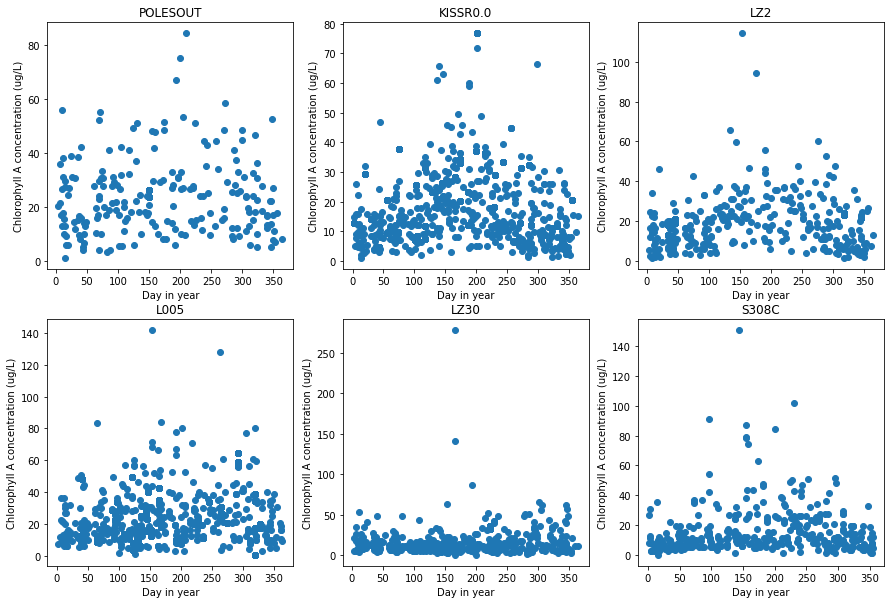

In [12]:
nrow, ncol = 2, 3
fig = plt.figure(figsize=(5*ncol,5*nrow))
i = 0 
for station in ["POLESOUT", "KISSR0.0", "LZ2", "L005", "LZ30", "S308C"]:
    data = Data_clean_up_3(pd.read_csv(f"{station}.csv"), monthly_average=False)
    data["Date in year"] = list(map(lambda date: date.timetuple().tm_yday,
                                data["Collection_Date"]))
    i += 1
    ax = fig.add_subplot(nrow, ncol, i)
    ax.scatter(data["Date in year"], data["FINAL CHLOROPHYLL-A"])
    ax.set_title(station)
    ax.set_ylabel("Chlorophyll A concentration (ug/L)")
    ax.set_xlabel("Day in year")

In [16]:
station = 'POLESOUT'
data = Data_clean_up_3(pd.read_csv(f"{station}.csv"), monthly_average=False)
data["Collection_Month"] = list(map(lambda date: date.month,
                                   data['Collection_Date']))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


In [24]:
mean_month_array = []
std_month_array = []
for month in range(1,13,1):
    values = data.loc[data["Collection_Month"]==month, "FINAL CHLOROPHYLL-A"]
    mean_month_array.append(np.mean(values))
    std_month_array.append(np.std(values))

<ErrorbarContainer object of 3 artists>

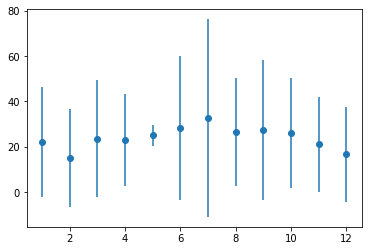

In [25]:
plt.errorbar(x=range(1,13,1), y=np.array(mean_month_array), yerr=1.96*np.array(std_month_array),
            fmt="o")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


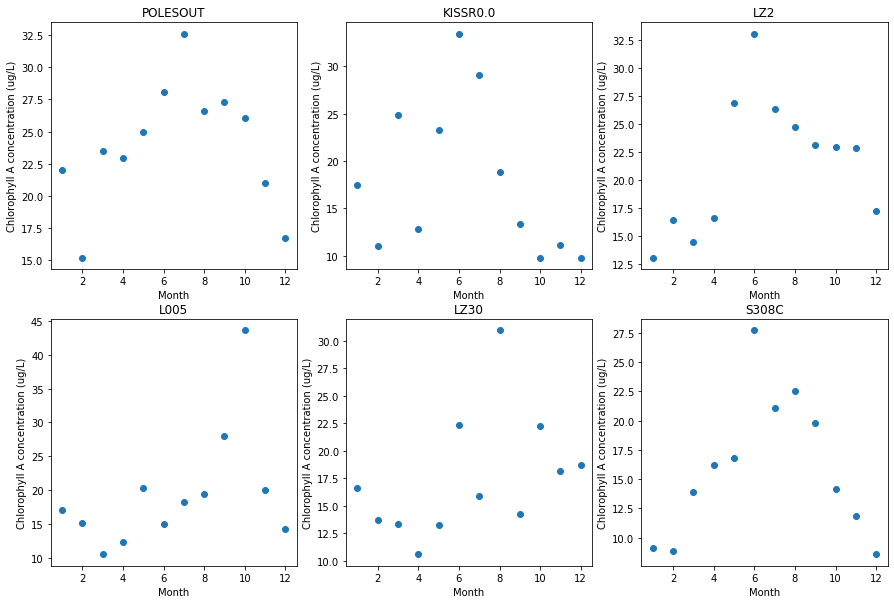

In [29]:
nrow, ncol = 2, 3
fig = plt.figure(figsize=(5*ncol,5*nrow))
i = 0 
for station in ["POLESOUT", "KISSR0.0", "LZ2", "L005", "LZ30", "S308C"]:
    data = Data_clean_up_3(pd.read_csv(f"{station}.csv"), monthly_average=False)
    data["Collection_Month"] = list(map(lambda date: date.month,
                                       data['Collection_Date']))
    i += 1
    mean_month_array = []
    for month in range(1,13,1):
        values = data.loc[data["Collection_Month"]==month, "FINAL CHLOROPHYLL-A"]
        mean_month_array.append(np.mean(values))
        
    ax = fig.add_subplot(nrow, ncol, i)
    ax.scatter(range(1,13,1), mean_month_array)
    ax.set_title(station)
    ax.set_ylabel("Chlorophyll A concentration (ug/L)")
    ax.set_xlabel("Month")

In [30]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

In [38]:
y

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
2213    31.50
2214    16.00
2215    32.30
2216     9.67
2217     4.20
Name: FINAL CHLOROPHYLL-A, Length: 2218, dtype: float64

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


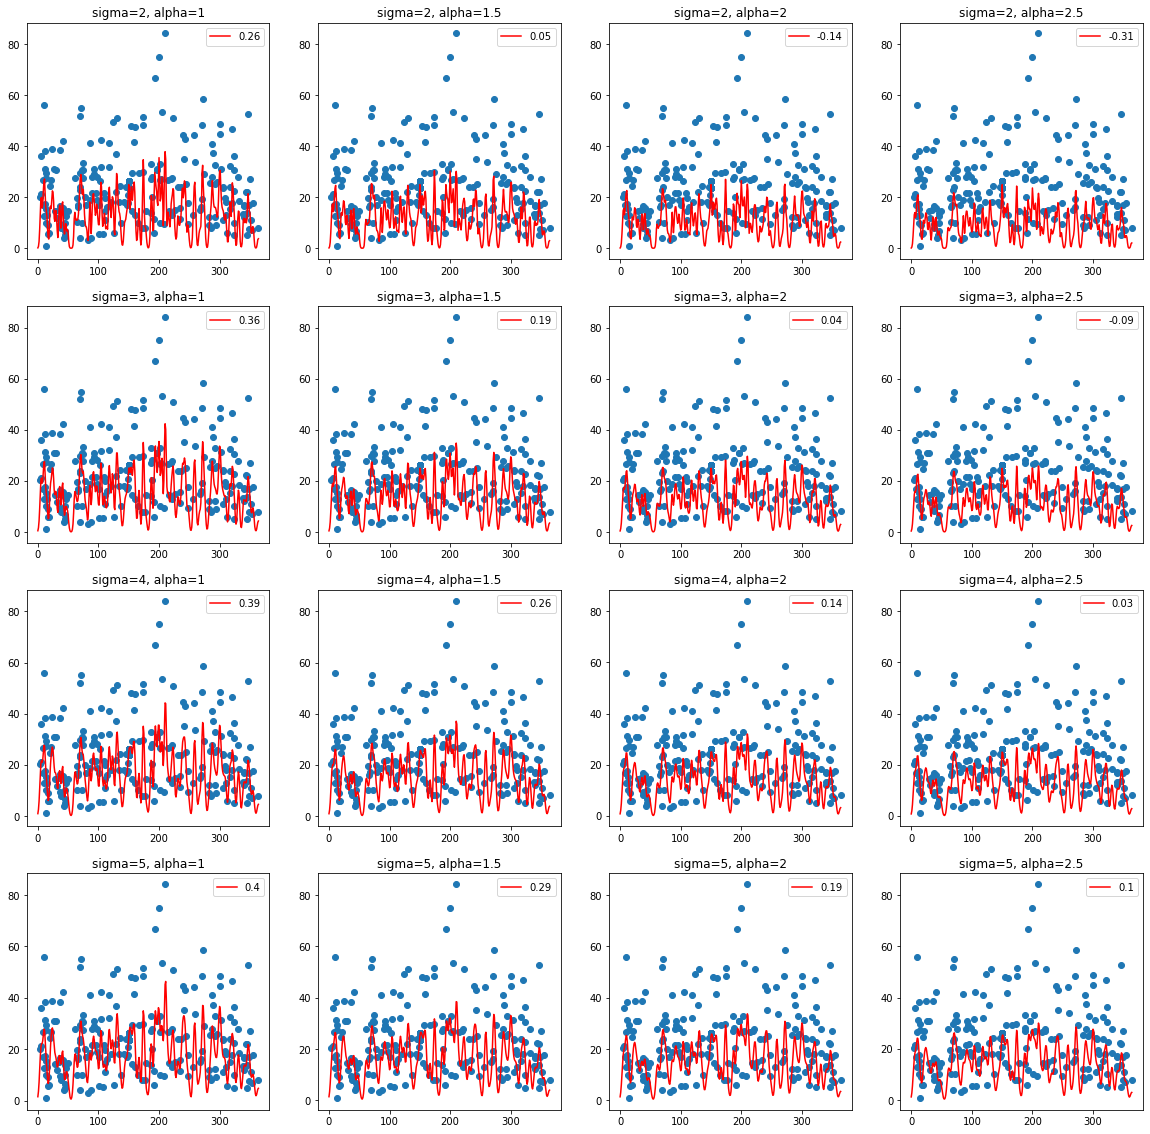

In [43]:
station="POLESOUT"
data = Data_clean_up_3(pd.read_csv(f"{station}.csv"), monthly_average=False)
data["Date in year"] = list(map(lambda date: date.timetuple().tm_yday,
                            data["Collection_Date"]))
data = data[["Date in year","FINAL CHLOROPHYLL-A"]].dropna()
X1 = data["Date in year"]
y = data["FINAL CHLOROPHYLL-A"]
X1 = np.array(X1).reshape(-1,1)

centers = np.linspace(0,365,200).reshape(-1, 1)
fig = plt.figure(figsize=(20,20))
i = 0
for sigma in [2,3,4,5]:
    for alpha in [1,1.5,2,2.5]:
        i += 1
        # New representation:
        X1_new = rbf_kernel(X1, centers, gamma=1.0/sigma)
        regr = Ridge(alpha=alpha, fit_intercept=False)
        regr.fit(X1_new, y)

        all_X1 = np.arange(0,365).reshape(-1, 1)
        # New representation:
        all_X1_new = rbf_kernel(all_X1, centers, gamma=1/sigma)
        pred_y = regr.predict(all_X1_new)
        ax = fig.add_subplot(4, 4, i)
        ax.scatter(X1, y)
        ax.plot(all_X1, pred_y, color="red", label=round(regr.score(X1_new, y),2))
        ax.legend()
        ax.set_title(f"sigma={sigma}, alpha={alpha}")